# 1. Importing Libraries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score,root_mean_squared_error
import numpy as np
import seaborn as sns
from sklearn.model_selection import learning_curve
import statsmodels.api as sm

# 2. Loading and Exploring the Data

In [2]:
df = pd.read_csv('data/cardekho.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                8128 non-null   object 
 1   year                8128 non-null   int64  
 2   selling_price       8128 non-null   int64  
 3   km_driven           8128 non-null   int64  
 4   fuel                8128 non-null   object 
 5   seller_type         8128 non-null   object 
 6   transmission        8128 non-null   object 
 7   owner               8128 non-null   object 
 8   mileage(km/ltr/kg)  7907 non-null   float64
 9   engine              7907 non-null   float64
 10  max_power           7913 non-null   object 
 11  seats               7907 non-null   float64
dtypes: float64(3), int64(3), object(6)
memory usage: 762.1+ KB


In [4]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.2,5.0


# 3. Data Cleaning and Preparation

In [5]:
df.drop(columns=['name','seller_type'], inplace=True)

In [6]:
perc = np.percentile(df['selling_price'],q=(0,100))
df = df[(perc[0]<df['selling_price']) & (df['selling_price']<perc[1])].reset_index(drop=True)

In [7]:
df['age'] = 2024 - df['year']

df.drop(columns='year',inplace=True)

In [8]:
df['max_power'] = df['max_power'].replace(' ', np.nan)
df.loc[:,'max_power'] = df.loc[:,'max_power'].astype(float)

In [9]:
df['fuel'].value_counts()
# df['seller_type'].value_counts()

fuel
Diesel    4402
Petrol    3629
CNG         57
LPG         38
Name: count, dtype: int64

# 4. Pre-Processing Data


## Scaling data

In [10]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler(feature_range=(0,1))

df[['selling_price','km_driven','engine']] = minmax.fit_transform(df[['selling_price','km_driven','engine']])

## Imputing Missing Data

In [11]:
columns_with_nan = [column for column in df.columns if df[column].isna().sum()>0]

iter = IterativeImputer(initial_strategy='mean')
df[columns_with_nan] = iter.fit_transform(df[columns_with_nan])

## Encoding data

In [12]:
# Fit the onehotEncoder
onehot = OneHotEncoder(sparse_output=False)
onehot.fit_transform(df.select_dtypes(object))

temp = pd.DataFrame(columns = onehot.get_feature_names_out(), data= onehot.fit_transform(df.select_dtypes(object)))

df = pd.concat([df,temp],axis=1).drop(columns=df.select_dtypes('object').columns)

# 5. Model Building and Training


In [13]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='selling_price'), df['selling_price'], test_size=0.2)

## Functions

### Metrics 

In [14]:
lista_metrics = []
def save_metrics(model,y_test,predictions):
    r2 = r2_score(y_test, predictions)
    rmse = root_mean_squared_error(y_test, predictions)
    lista_metrics.append([model.__class__.__name__,r2,rmse])

### Feature Importance

In [15]:
def plot_importance(model):
    feature_less_importance = [feature  for feature, importance in dict(zip(model.feature_names_in_, model.feature_importances_)).items() if importance < 0.1]
    others = sum([importance  for feature, importance in dict(zip(model.feature_names_in_, model.feature_importances_)).items() if feature in feature_less_importance])

    feature_importance = pd.DataFrame(model.feature_importances_, index=model.feature_names_in_,columns=['importance']).drop(index=feature_less_importance)
    feature_importance.loc['others']=others

    plt.figure(figsize=(10, 3))
    bars = plt.bar(feature_importance.index, feature_importance.importance.values)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

    plt.title(f'Feature Importance - {model.__class__.__name__}')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.ylim(0,1)
    plt.xticks(rotation=0)
    plt.show()

### Scatter Plot

In [16]:
def scatter_plot(y_test, predictions, model):
    plt.figure(figsize=(8, 4))
    plt.scatter(y_test, predictions, color='blue', alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # diagonal
    plt.title(f'Scatter Plot - {model.__class__.__name__}')
    plt.xlabel('True Values')
    plt.ylabel('Predict Values')
    plt.grid(True)
    plt.show()

### Residual Plot

In [17]:
def residual_plot(y_test,predictions, model):
    residuos = [real - pred for real, pred in zip(y_test, predictions)]
    plt.figure(figsize=(8, 4))
    plt.scatter(predictions, residuos, color='blue', alpha=0.7)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residual plot  - {model.__class__.__name__}')
    plt.xlabel('Predict Values')
    plt.ylabel('Scraps')
    plt.grid(True)
    plt.show()

### Q-Q Plot

In [18]:
def qqplot(y_test, predictions, model):
    residuos = np.array([real - pred for real, pred in zip(y_test, predictions)])
    sm.qqplot(residuos, line='45')
    plt.title(f'Q-Q plot | {model.__class__.__name__}')
    plt.show()

### Learning Curve

In [19]:
def plot_learning_curve(model, x_test, y_test):
    train_sizes, train_scores, test_scores = learning_curve(model, x_test, y_test, cv=5, scoring='r2', n_jobs=-1)
    
    train_mean = -np.mean(train_scores, axis=1)
    test_mean = -np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, label="Training", color="blue")
    plt.plot(train_sizes, test_mean, label="Validation", color="green")
    plt.xlabel('Training set size')
    plt.ylabel('r2 score') 
    plt.legend(loc="best")
    plt.title(f"Learning Curve | {model.__class__.__name__}")
    plt.show()


## `Decision Tree Regressor`

In [20]:
dtr = DecisionTreeRegressor(max_depth=15, criterion='poisson')

dtr.fit(x_train,y_train)
predictions_1 = dtr.predict(x_test)
save_metrics(dtr,y_test,predictions_1)

### Importance Features

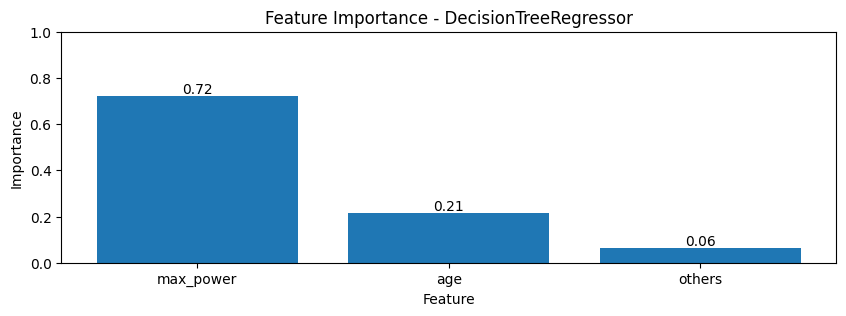

In [21]:
plot_importance(dtr)

### Scatter Plot

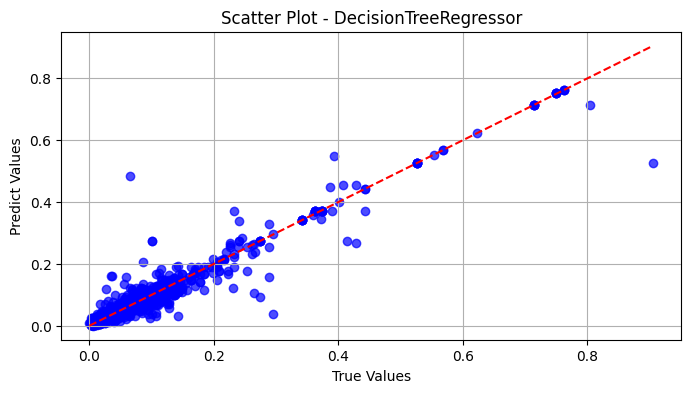

In [22]:
scatter_plot(y_test,predictions_1,dtr)

### Residual Plot

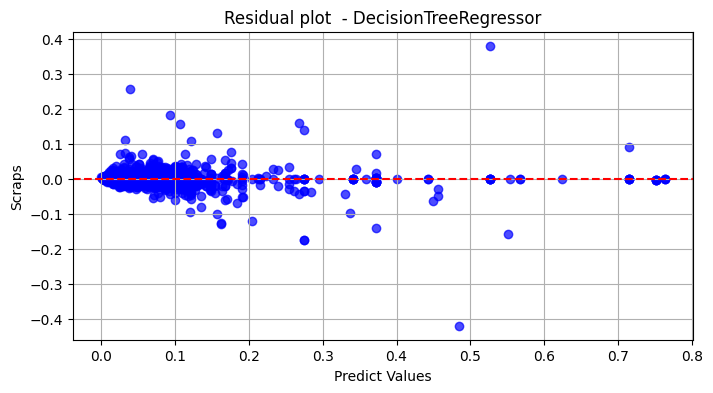

In [23]:
residual_plot(y_test,predictions_1,dtr)

### Q-Q Plot

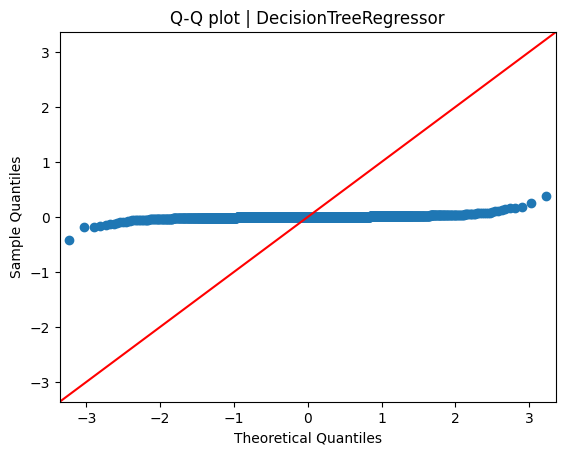

In [24]:
qqplot(y_test, predictions_1, dtr)

### Learning Curve

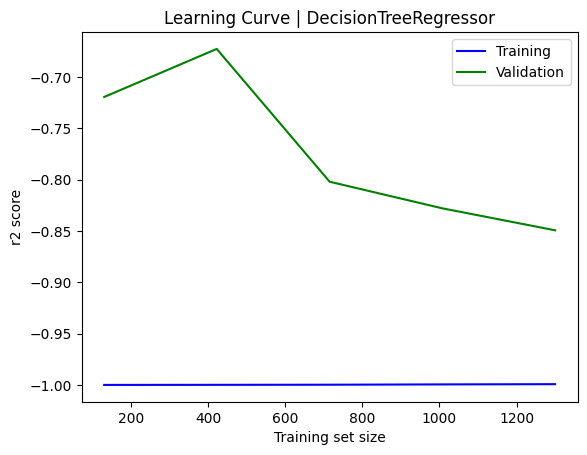

In [25]:
plot_learning_curve(dtr,x_test,y_test)

## `Random Forest`

In [26]:
rfr = RandomForestRegressor(n_estimators=200,criterion='friedman_mse',max_depth=15)

rfr.fit(x_train,y_train)
predictions_2 = rfr.predict(x_test)
save_metrics(rfr,y_test,predictions_2)

### Importance Features

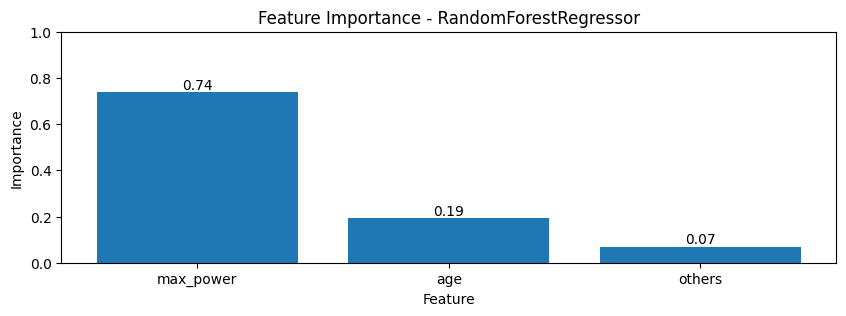

In [27]:
plot_importance(rfr)

### Scatter Plot

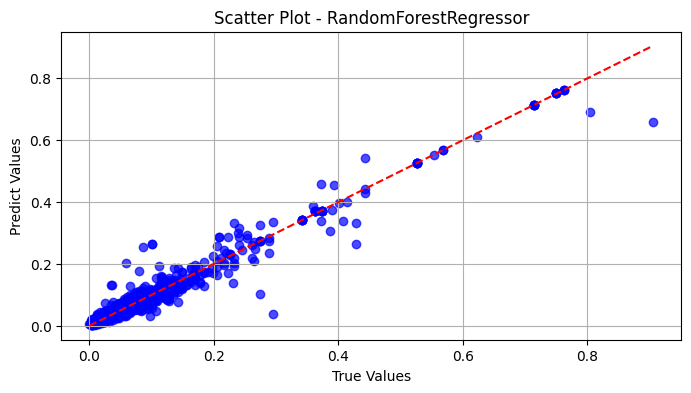

In [28]:
scatter_plot(y_test,predictions_2,rfr)

### Residual Plot

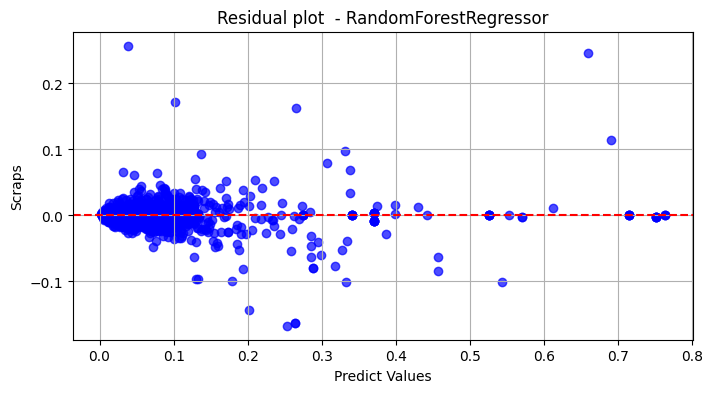

In [29]:
residual_plot(y_test,predictions_2,rfr)

### Q-Q Plot

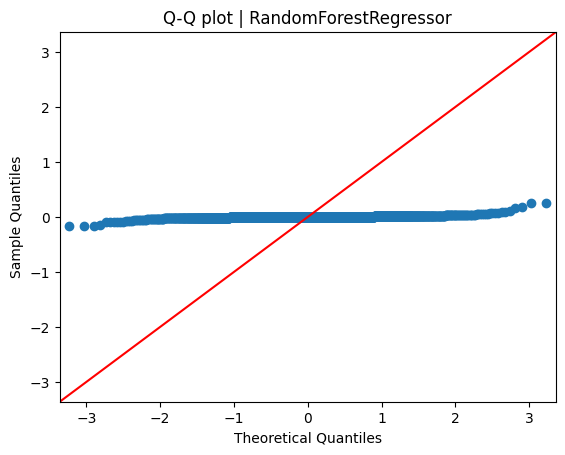

In [30]:
qqplot(y_test, predictions_2, rfr)

### Learning Curve

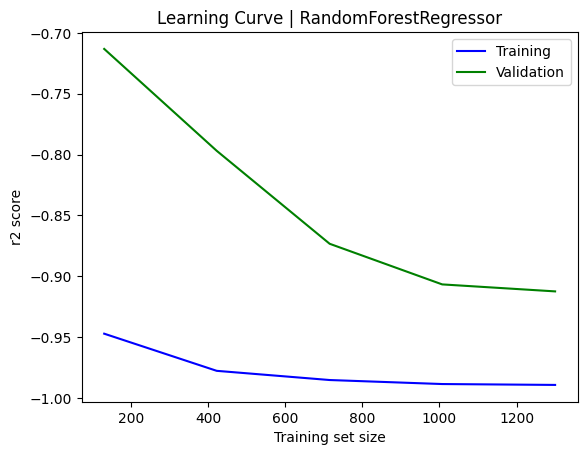

In [31]:
plot_learning_curve(rfr,x_test,y_test)

## `Decision Tree Regressor with Bagging`

In [32]:
bagg = BaggingRegressor(estimator=DecisionTreeRegressor(criterion='squared_error',max_depth=20),n_estimators=200)

bagg.fit(x_train,y_train)
predictions_3 = bagg.predict(x_test)
save_metrics(bagg,y_test,predictions_3)

### Importance Features

### Scatter Plot

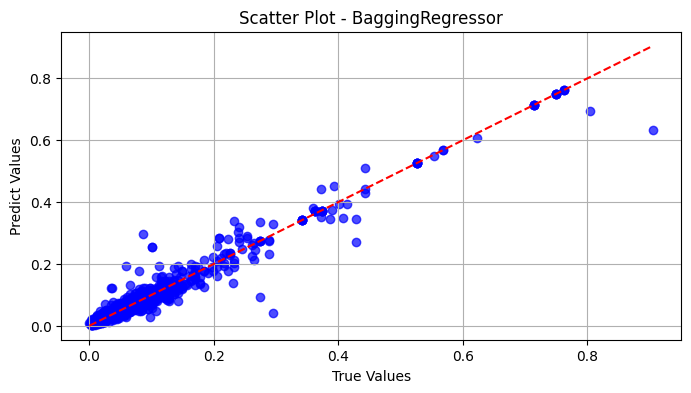

In [33]:
scatter_plot(y_test,predictions_3,bagg)

### Residual Plot

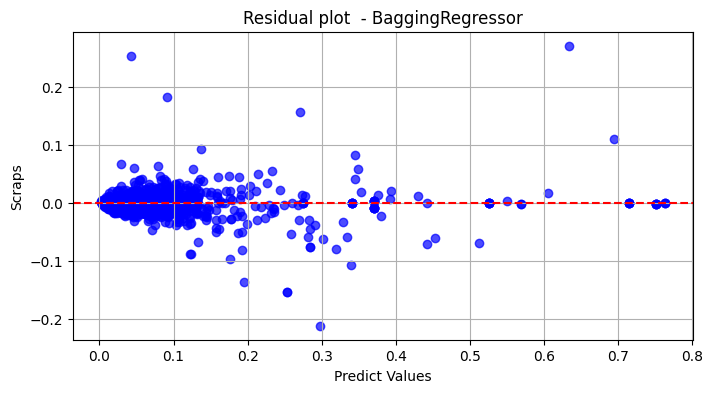

In [34]:
residual_plot(y_test,predictions_3,bagg)

### Q-Q Plot

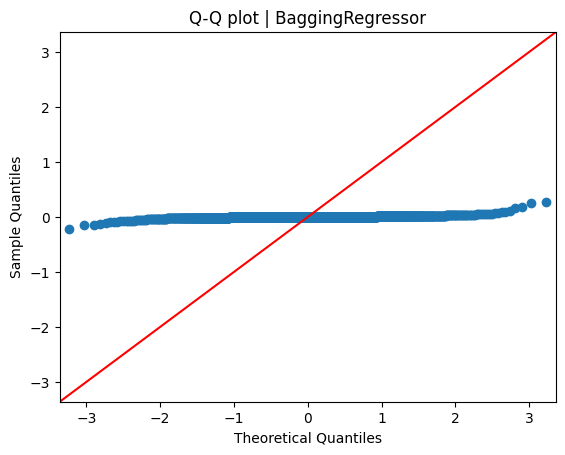

In [35]:
qqplot(y_test, predictions_3, bagg)

### Learning Curve

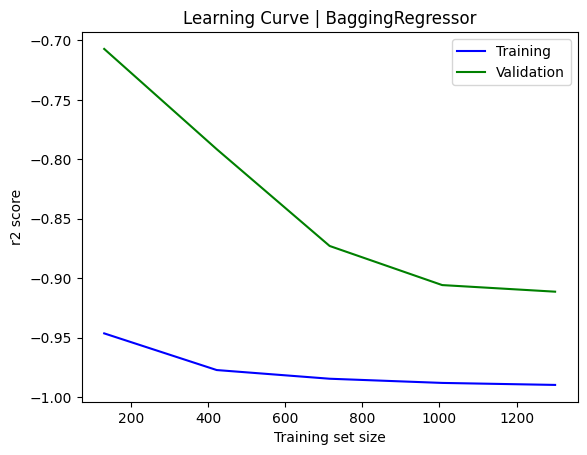

In [36]:
plot_learning_curve(bagg,x_test,y_test)

## `Gradient Boosting`

In [37]:
gbr = GradientBoostingRegressor(criterion='friedman_mse', learning_rate=0.05,loss='absolute_error',n_estimators=200)

gbr.fit(x_train,y_train)
predictions_4 = gbr.predict(x_test)
save_metrics(gbr,y_test,predictions_4)

### Importance Features

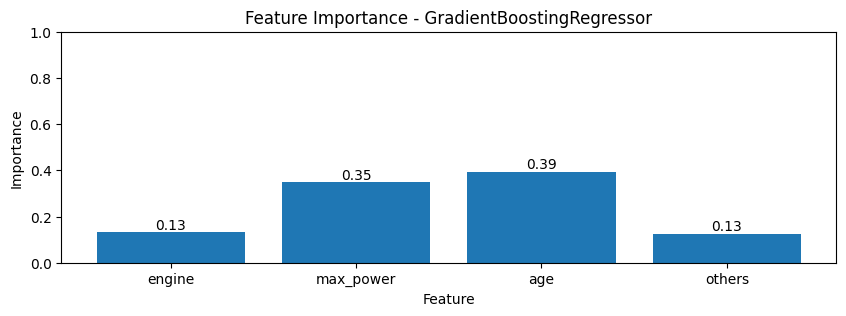

In [38]:
plot_importance(gbr)

### Scatter Plot

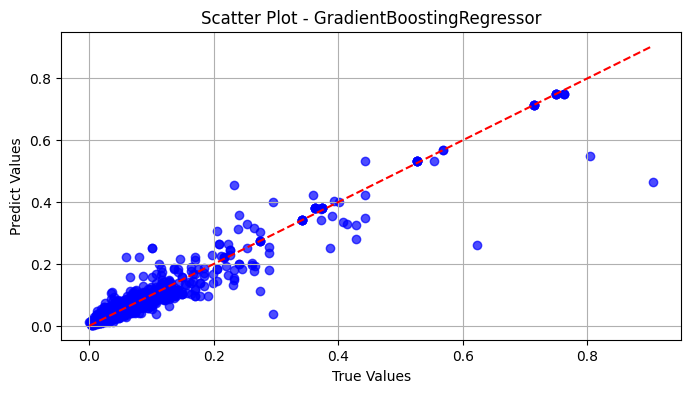

In [39]:
scatter_plot(y_test,predictions_4,gbr)

### Residual Plot

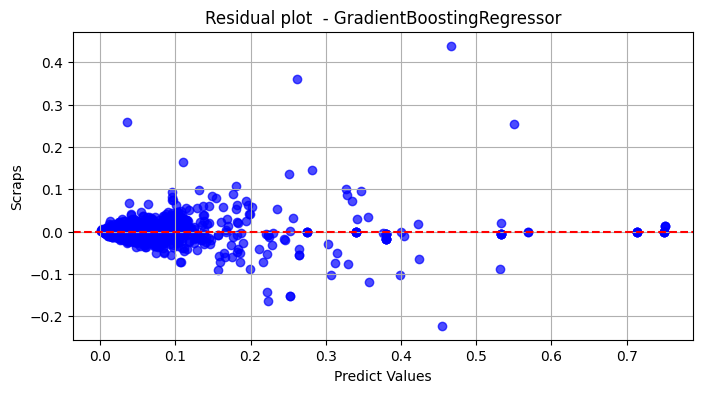

In [40]:
residual_plot(y_test,predictions_4,gbr)

### Q-Q Plot

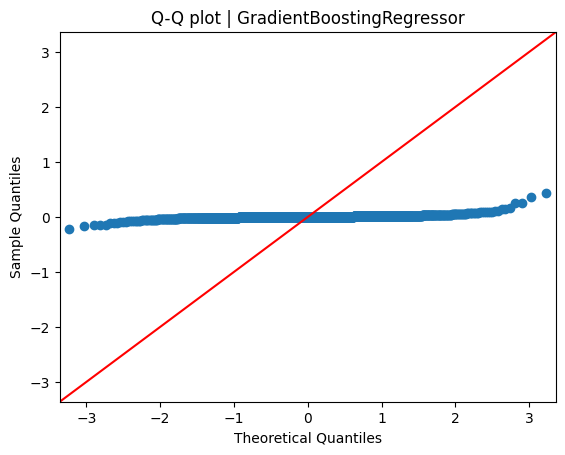

In [41]:
qqplot(y_test, predictions_4, gbr)

### Learning Curve

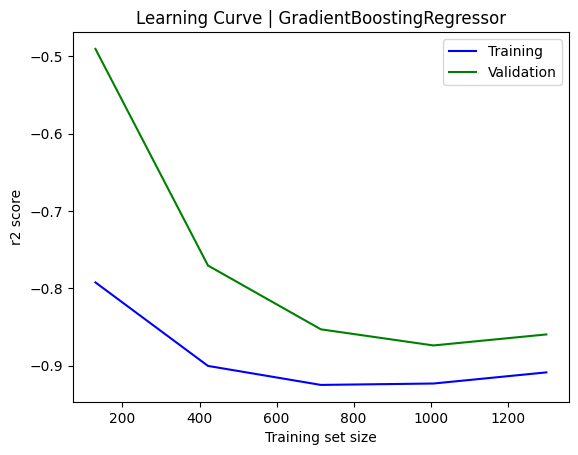

In [42]:
plot_learning_curve(gbr,x_test,y_test)

## `Adaptive Boost`

In [43]:
ada = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=20,criterion='friedman_mse'), n_estimators=200, learning_rate=0.1, loss='exponential')

ada.fit(x_train, y_train)
predictions_5 = ada.predict(x_test)

ada.fit(x_train,y_train)
predictions_5 = dtr.predict(x_test)

save_metrics(ada,y_test,predictions_5)

### Importance Features

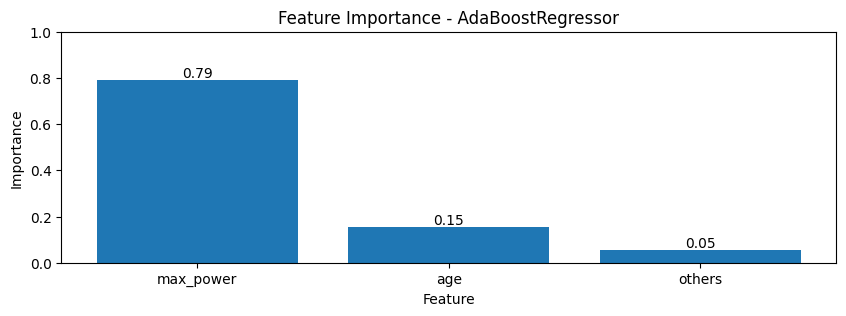

In [44]:
plot_importance(ada)

### Scatter Plot

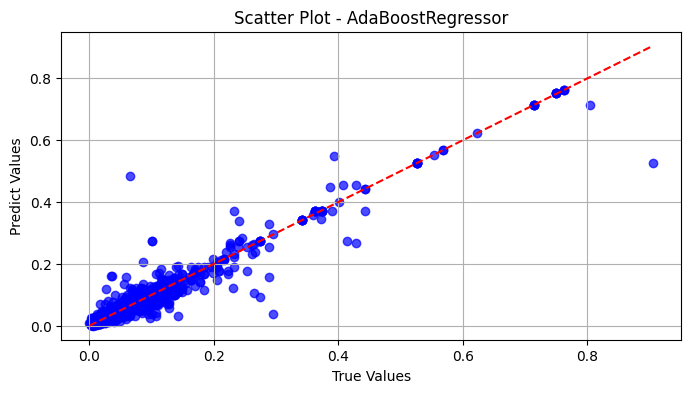

In [45]:
scatter_plot(y_test,predictions_5,ada)

### Residual Plot

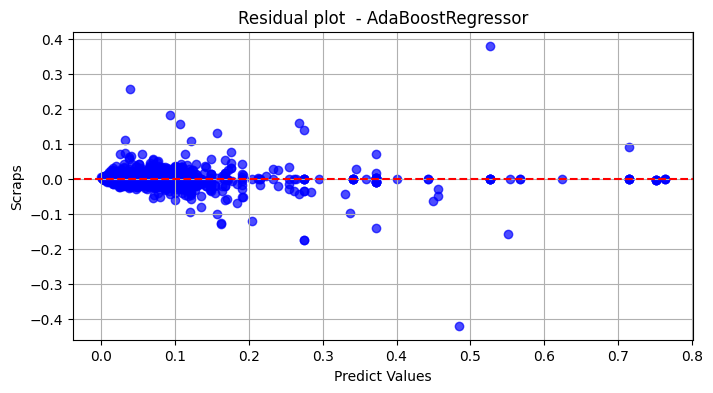

In [46]:
residual_plot(y_test,predictions_5,ada)

### Q-Q Plot

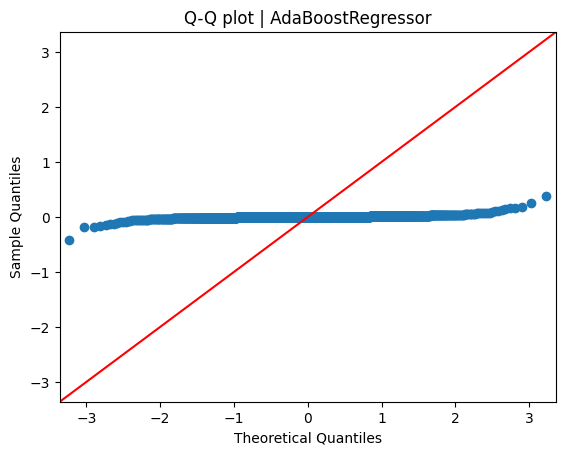

In [47]:
qqplot(y_test, predictions_5, ada)

### Learning Curve

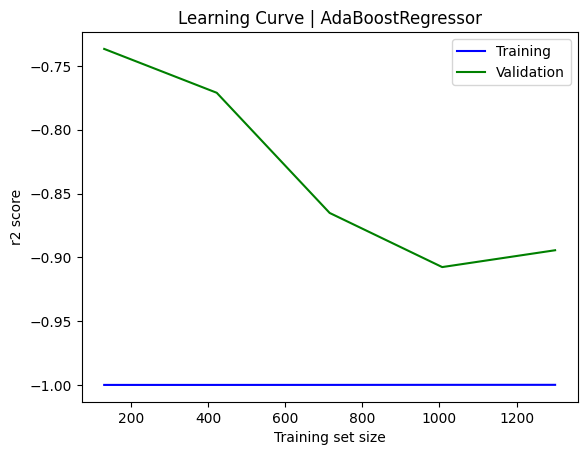

In [48]:
plot_learning_curve(ada,x_test,y_test)

## `XGBoost`

In [49]:
import xgboost as xgb
xgbr = xgb.XGBRegressor(booster='gbtree', objective='reg:squarederror', eval_metric = 'rmse')

xgbr.fit(x_train,y_train)
predictions_6 = xgbr.predict(x_test)
save_metrics(xgbr,y_test,predictions_6)

### Importance Features

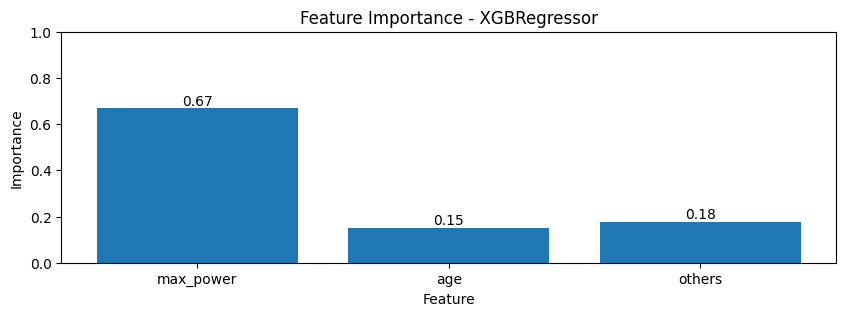

In [50]:
plot_importance(xgbr)

### Scatter Plot

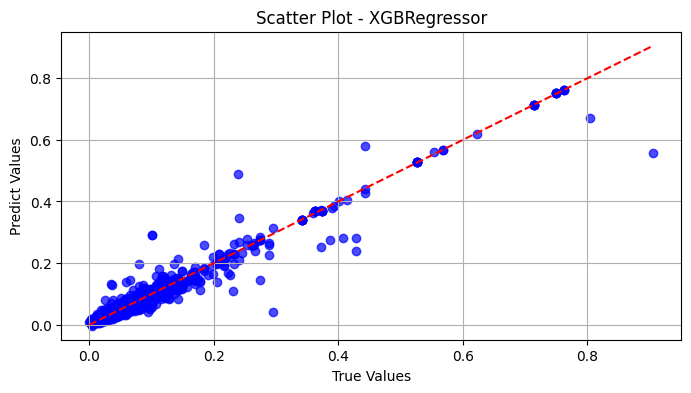

In [51]:
scatter_plot(y_test,predictions_6,xgbr)

### Residual Plot

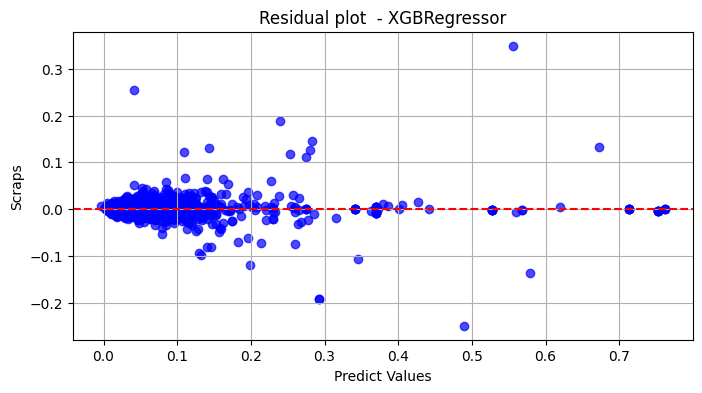

In [52]:
residual_plot(y_test,predictions_6,xgbr)

### Q-Q Plot

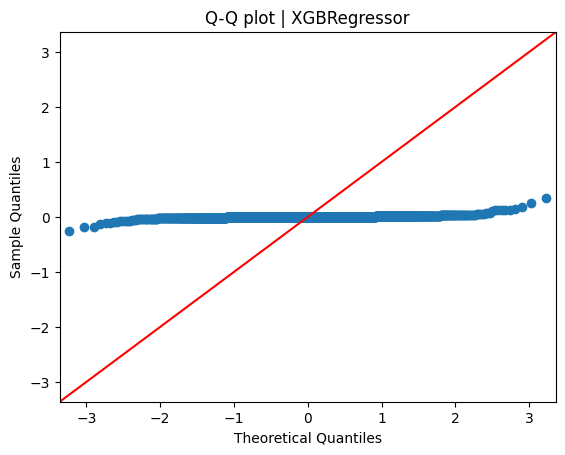

In [53]:
qqplot(y_test, predictions_6, xgbr)

### Learning Curve

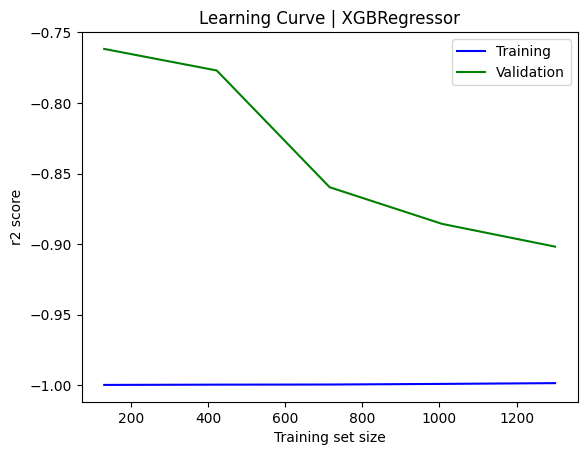

In [54]:
plot_learning_curve(xgbr,x_test,y_test)

# 6. Model Evaluation

The evaluation of the regression models reveals that both the **BaggingRegressor** and **RandomForestRegressor** show the best performance, with an \( R^2 \) of about 0.958 and an RMSE of around 0.020. These results indicate that these models have a significant ability to explain the variability of the data and produce predictions very close to the actual values. On the other hand, the **XGBRegressor** also exhibits a solid, though slightly lower, performance, with an \( R^2 \) of 0.951 and an RMSE of 0.022.

However, despite these good scores, it is concerning that none of the models show a learning curve that converges. This suggests that although the models perform well in terms of \( R^2 \) and RMSE, they might be facing problems such as overfitting or lack of generalization. Lack of convergence in the learning curves indicates that the model is not learning optimally from the training data, which may imply that there are aspects of the data that are not being adequately represented or that hyperparameter tuning and/or additional feature engineering are required to improve predictive ability. It is crucial to further investigate these aspects to optimize model performance.

In [55]:
pd.DataFrame(lista_metrics, columns=['model','r2','rmse']).sort_values(by='rmse', ascending=True)

,model,r2,rmse
2,BaggingRegressor,0.958589,0.020162
1,RandomForestRegressor,0.958537,0.020175
5,XGBRegressor,0.950877,0.021959
0,DecisionTreeRegressor,0.932984,0.025649
4,AdaBoostRegressor,0.932984,0.025649
3,GradientBoostingRegressor,0.922036,0.027665
